In [6]:
from src.influx_db.influx_utils import InfluxUtils
from influxdb import InfluxDBClient
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from src import *
sns.set(font_scale=1.4)

In [3]:
client = InfluxDBClient()
client.switch_database(client.get_list_database()[1]['name'])
influxUtils = InfluxUtils(client=client)
print('Total of ' + str(len(client.get_list_measurements())) + " measurements.")

Total of 2832 measurements.


In [4]:
start_processing_time = time.time()
stocks_summary = [influxUtils.get_stock_summary(x) for x in list(map(lambda x: x['name'], client.get_list_measurements()))]
stocks_total_days = list(map(lambda x: x['total_days'], stocks_summary))
stocks_total_trading_days = list(map(lambda x: x['total_trading_days'], stocks_summary))
print('Total processing time: ' + str(time.time() - start_processing_time) + ' seconds.')

Total processing time: 73.92965054512024 seconds.


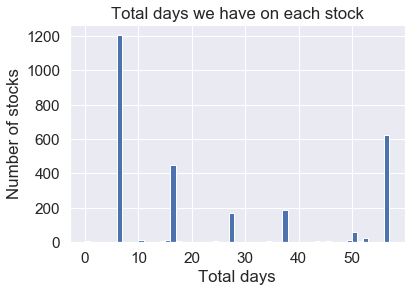

There are 605 stocks with full data (57 days)


In [24]:
total_days_hist_values = plt.hist(stocks_total_days, bins=range(1 + int(max(stocks_total_days))))
plt.title('Total days we have on each stock')
plt.xlabel('Total days')
plt.ylabel('Number of stocks')
plt.show()
print("There are " + str((stocks_total_days.count(max(stocks_total_days)))) + " stocks with full data (" + str(int(max(stocks_total_days))) + " days)")

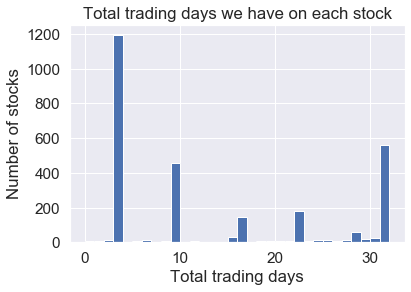

There are 467 stocks with full trading data (32 days)


In [25]:
total_trading_days_hist_values = plt.hist(stocks_total_trading_days, bins=range(1 + int(max(stocks_total_trading_days))))
plt.title('Total trading days we have on each stock')
plt.xlabel('Total trading days')
plt.ylabel('Number of stocks')
plt.show()
print("There are " + str((stocks_total_trading_days.count(max(stocks_total_trading_days)))) + " stocks with full trading data (" + str(int(max(stocks_total_trading_days))) + " days)")

<h1>To sum up so far:</h1>
<h3>We collected data on 2832 stocks from NASDAQ stock market.<br>
Unfortunatly, we were able to collect full data (57 days) only with 605 stocks, which only 467 out of them contains the maximum of 32 trading days.

Let's keep the 605 stocks with full information from now on.</h3>

In [6]:
# get a list of all stocks which have full information
full_data_stocks = np.array([x['symbol'] if x['total_days'] == max(stocks_total_days) else 'None' for x in stocks_summary])
full_data_stocks = list(full_data_stocks[full_data_stocks != 'None'])

In [26]:
start_processing_time = time.time()
full_stocks_summary = [influxUtils.get_stock_summary(x) for x in full_data_stocks]
full_stocks_total_trading_days = list(map(lambda x: x['total_trading_days'], full_stocks_summary))
print('Total processing time: ' + str(time.time() - start_processing_time) + ' seconds.')

Total processing time: 38.779494285583496 seconds.


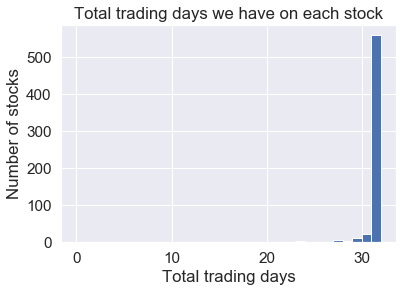

There are still 467 stocks with full trading data (32 days), with a minimum of 23 days.


In [27]:
full_stocks_trading_days_hist = plt.hist(full_stocks_total_trading_days, bins=range(1 + int(max(full_stocks_total_trading_days))))
plt.title('Total trading days we have on each stock')
plt.xlabel('Total trading days')
plt.ylabel('Number of stocks')
plt.show()
print("There are still " + str((full_stocks_total_trading_days.count(max(full_stocks_total_trading_days)))) + " stocks with full trading data (" + str(int(max(full_stocks_total_trading_days))) + " days), with a minimum of " + str(int(min(full_stocks_total_trading_days))) + " days.")

In [28]:
df = pd.read_csv('influx_db/nasdaq_stocks.csv').filter(items=['Symbol', 'Sector']).fillna({'Sector': 'No Sector'})
print('The df shape is: ' + str(df.shape))
df.head(21)


The df shape is: (2838, 2)


Symbol             Sector
0    AACG  Consumer Services
1    AACQ            Finance
2     AAL     Transportation
3    AAME            Finance
4    AAOI         Technology
5    AAON      Capital Goods
6    AAPL         Technology
7    AAWW     Transportation
8    ABCB            Finance
9    ABCL        Health Care
10   ABCM        Health Care
11   ABEO        Health Care
12   ABMD        Health Care
13   ABNB            Finance
14   ABST         Technology
15   ABTX            Finance
16   ABUS        Health Care
17   ACAC            Finance
18   ACAD        Health Care
19   ACBI            Finance
20   ACCD          No Sector

<h3>Now, let's analyze the sectors of our stocks</h3>

Total of 13 sectors: ['Basic Industries' 'Capital Goods' 'Consumer Durables'
 'Consumer Non-Durables' 'Consumer Services' 'Energy' 'Finance'
 'Health Care' 'Miscellaneous' 'No Sector' 'Public Utilities' 'Technology'
 'Transportation']


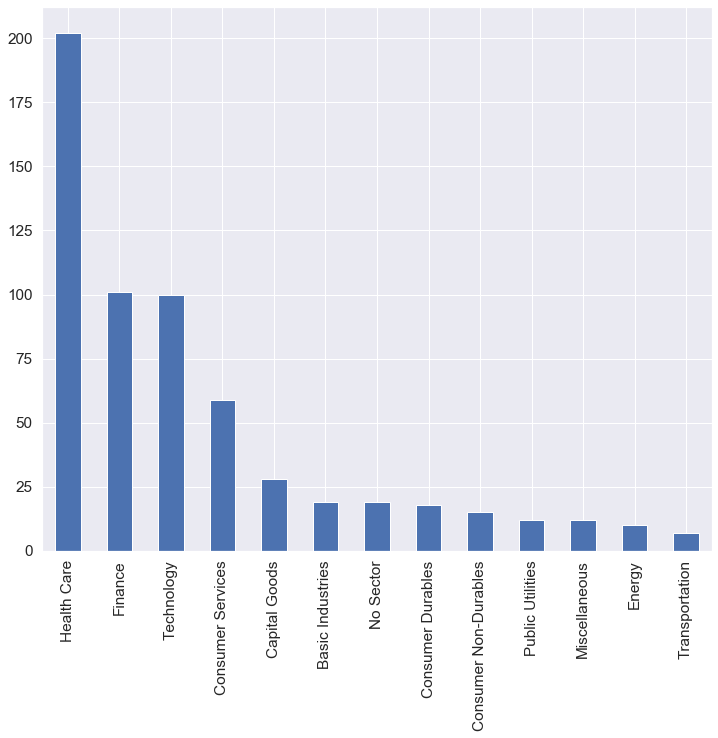

In [29]:
full_stocks_df = df[[x in full_data_stocks for x in df['Symbol']]]['Sector']
counts = full_stocks_df.value_counts()
counts.plot(kind='bar',figsize=(12, 10))
print('Total of ' + str(counts.shape[0]) + ' sectors: ' + str(np.unique(counts.index)))

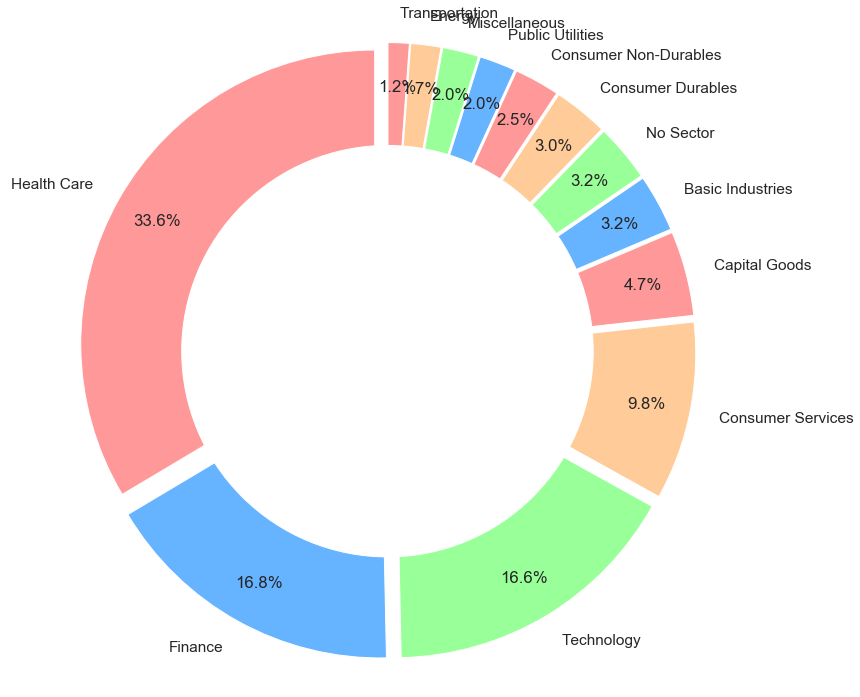

In [30]:
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
#explsion
explode = tuple([0.05]*len(counts.index))

fig1, ax1 = plt.subplots(figsize=(12, 10))
ax1.pie(counts.values, colors = colors, labels=counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

In [7]:
max_days_filter = FilterEnum.MaximumDays.get()
stocks_data = max_days_filter.get_filtered_data()
pd.Series([len(stocks_data[x][0]) for x in stocks_data.keys()]).describe()

Process took: 106.25309491157532


count     605.000000
mean     2859.953719
std        73.367179
min      2080.000000
25%      2880.000000
50%      2880.000000
75%      2880.000000
max      2928.000000
dtype: float64

In [31]:
from pandas.core.algorithms import quantile
import numpy as np
from numpy import quantile
quantile(np.array([len(stocks_data[x][0]) for x in stocks_data.keys()]), np.arange(0.05,1,0.05), interpolation='nearest')

array([2744, 2834, 2868, 2877, 2880, 2880, 2880, 2880, 2880, 2880, 2880,
       2880, 2880, 2880, 2880, 2880, 2880, 2880, 2880])